In [77]:
#Import TensorFlow and other necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import logging
logging.getLogger('tensorflow').disabled = True

In [78]:
import warnings

warnings.filterwarnings('ignore')

In [27]:
# downloading data set
# dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos/', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 38s 0us/step


In [46]:
# total image count 
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


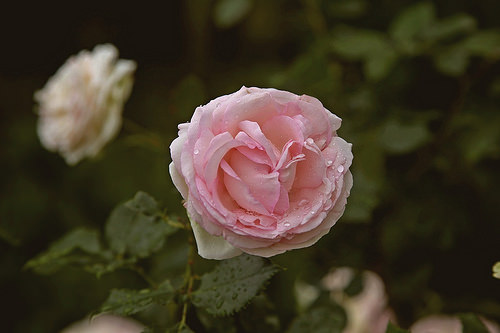

In [47]:
#  roses
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[100]))

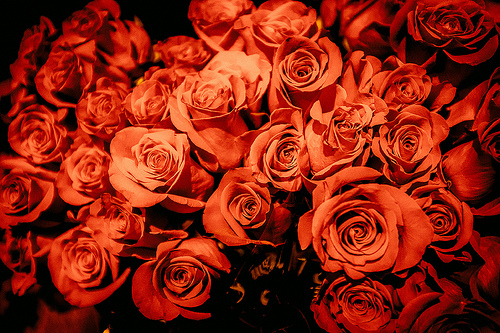

In [48]:
PIL.Image.open(str(roses[2]))

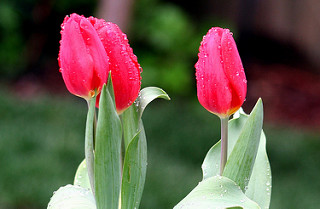

In [49]:
#tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

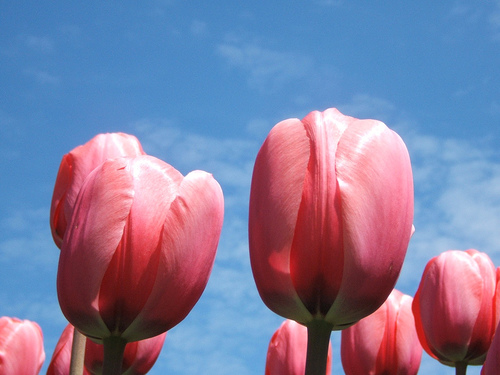

In [50]:
PIL.Image.open(str(tulips[199]))

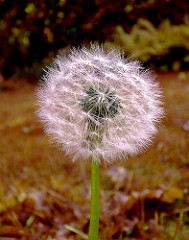

In [51]:
#dandelion
roses = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(roses[100]))

In [52]:
#Define some parameters for the loader

In [53]:
batch_size = 32
img_height = 180
img_width = 180

**folder sturucture**


--> flower_photo/

                  daisy/
  
                  dandelion/
  
                  roses/
  
                  sunflowers/
      
                  tulips/

In [54]:
# code to read the files and generating traing set
train_ds = tf.keras.utils.image_dataset_from_directory(
  'flower_photos/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [55]:
train_ds.class_names # to see the classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [56]:
# code to read the files and generating validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  'flower_photos/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [57]:
val_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

**Visualize the data**

Here are the first nine images from the training dataset:

In [58]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


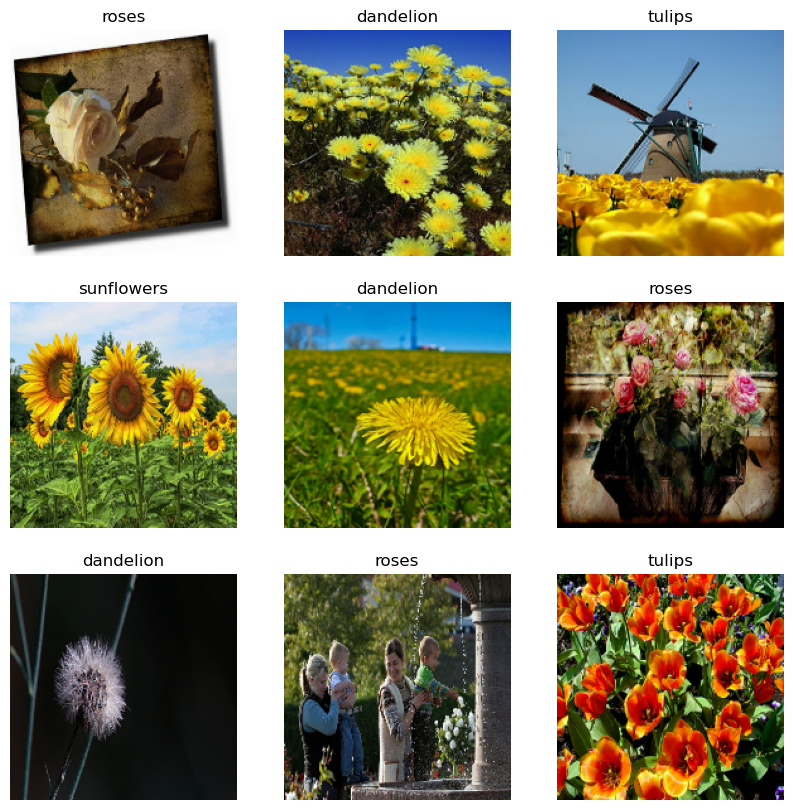

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**scaling of the data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

resized images using the image_size argument of tf.keras.utils.image_dataset_from_directory. If you want to include the resizing logic in your model as well, you can use the tf.keras.layers.Resizing layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [61]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

- The model takes an input image with shape (img_height, img_width, 3) and applies the Rescaling layer to normalize the pixel values to the range of [0,1].
- Then, it applies three 2D convolutional layers with 16, 32, and 64 filters respectively. Each convolutional layer uses a kernel size of 3x3 and the same padding to ensure the output feature maps have the same spatial dimensions as the input. The ReLU activation function is used to introduce non-linearity in the model.

- After each convolutional layer, the model applies a MaxPooling2D layer to downsample the feature maps and reduce the spatial dimensions of the output. This helps to reduce the number of parameters and computation required in the later stages of the model.

- Once the feature maps are downsampled, the model flattens the output using a Flatten layer to create a 1D vector of features. The flattened output is then passed through two fully connected (Dense) layers with 128 and num_classes neurons, respectively. The ReLU activation function is applied to the first Dense layer, while the second Dense layer does not have an activation function. The last layer produces the final output with a size equal to the number of classes to be predicted.


### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [64]:
# train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 18s 67ms/step - loss: 1.4347 - accuracy: 0.4155 - val_loss: 1.1085 - val_accuracy: 0.5286
Epoch 2/10
92/92 [==============================] - 5s 53ms/step - loss: 1.0393 - accuracy: 0.5954 - val_loss: 1.0025 - val_accuracy: 0.5954
Epoch 3/10
92/92 [==============================] - 5s 51ms/step - loss: 0.8774 - accuracy: 0.6700 - val_loss: 0.9140 - val_accuracy: 0.6458
Epoch 4/10
92/92 [==============================] - 5s 51ms/step - loss: 0.6731 - accuracy: 0.7537 - val_loss: 0.9304 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 5s 50ms/step - loss: 0.4610 - accuracy: 0.8372 - val_loss: 0.9970 - val_accuracy: 0.6621
Epoch 6/10
92/92 [==============================] - 5s 49ms/step - loss: 0.2708 - accuracy: 0.9138 - val_loss: 1.1984 - val_accuracy: 0.6226
Epoch 7/10
92/92 [==============================] - 5s 51ms/step - loss: 0.1487 - accuracy: 0.9567 - val_loss: 1.4070 - val_accuracy: 0.6349
Epoch 8/10
9

Visualize training results
Create plots of the loss and accuracy on the training and validation sets

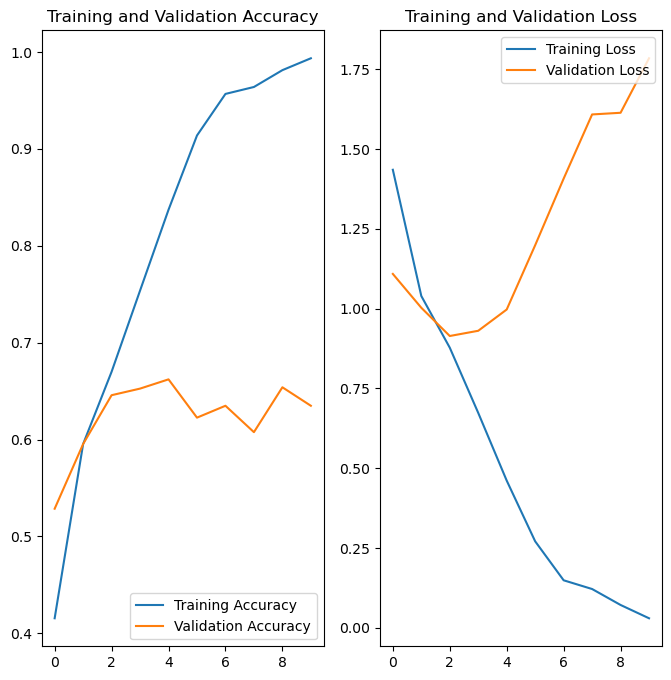

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).


There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

## Dropout


When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. command :`tf.keras.layers.Dropout` 

In [79]:
#data_augmentation

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

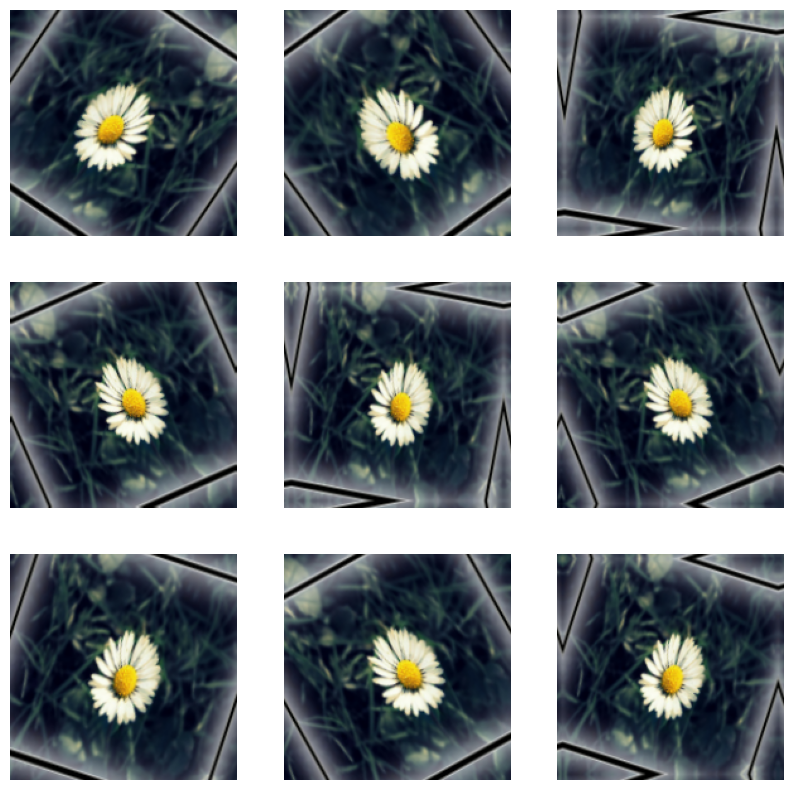

In [80]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [81]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [82]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [84]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 27s 267ms/step - loss: 1.4026 - accuracy: 0.3764 - val_loss: 1.1548 - val_accuracy: 0.5368
Epoch 2/15
92/92 [==============================] - 25s 269ms/step - loss: 1.0696 - accuracy: 0.5647 - val_loss: 1.0076 - val_accuracy: 0.5926
Epoch 3/15
92/92 [==============================] - 25s 269ms/step - loss: 0.9474 - accuracy: 0.6161 - val_loss: 0.9114 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 25s 268ms/step - loss: 0.8657 - accuracy: 0.6522 - val_loss: 0.9002 - val_accuracy: 0.6458
Epoch 5/15
92/92 [==============================] - 26s 285ms/step - loss: 0.8001 - accuracy: 0.6877 - val_loss: 0.8677 - val_accuracy: 0.6553
Epoch 6/15
92/92 [==============================] - 25s 272ms/step - loss: 0.7586 - accuracy: 0.6993 - val_loss: 0.8420 - val_accuracy: 0.6839
Epoch 7/15
92/92 [==============================] - 26s 281ms/step - loss: 0.7149 - accuracy: 0.7282 - val_loss: 0.8270 - val_accuracy: 0.6567

## Visualize training results

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned

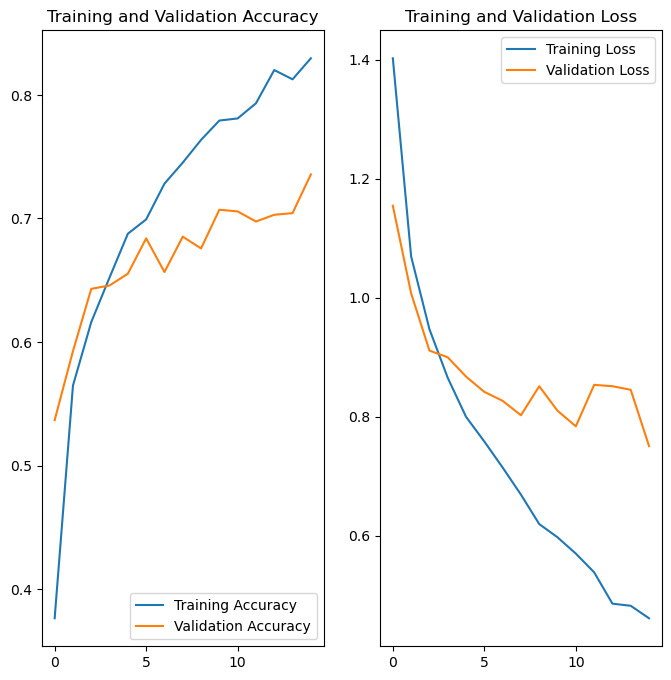

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [86]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
# getting an image for prediction

117948/117948 [==============================] - 0s 0us/step


In [87]:
sunflower_path

'C:\\Users\\HP\\.keras\\datasets\\Red_sunflower'

In [88]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


In [89]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
# loading the image   
#note keep the size of the image same as befor with which we have trained our model

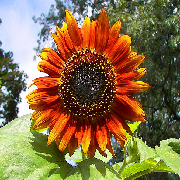

In [91]:
img

In [98]:
img.size

(180, 180)

In [92]:
img_array = tf.keras.utils.img_to_array(img)  # converting the image into arry 

In [93]:
img_array

array([[[151., 189., 252.],
        [152., 190., 253.],
        [154., 190., 252.],
        ...,
        [ 49.,  68.,  49.],
        [123., 124., 129.],
        [ 27.,   6.,  15.]],

       [[154., 192., 255.],
        [155., 191., 253.],
        [156., 192., 254.],
        ...,
        [ 34.,  61.,  28.],
        [ 29.,  75.,  49.],
        [ 27.,  71.,  44.]],

       [[158., 194., 255.],
        [155., 191., 253.],
        [158., 192., 253.],
        ...,
        [ 44.,  53.,  24.],
        [ 39.,  62.,  36.],
        [ 35.,  57.,  34.]],

       ...,

       [[124., 166.,  56.],
        [123., 164.,  62.],
        [172., 209., 113.],
        ...,
        [ 48.,  60.,  50.],
        [ 36.,  50.,  25.],
        [ 70.,  87.,  42.]],

       [[169., 219.,  98.],
        [129., 175.,  66.],
        [116., 160.,  49.],
        ...,
        [ 50.,  62.,  48.],
        [ 34.,  51.,  33.],
        [ 38.,  56.,  40.]],

       [[112., 168.,  33.],
        [125., 176.,  55.],
        [114., 1

In [99]:
img_array.shape

(180, 180, 3)

In [100]:
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [101]:
img_array

<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[151., 189., 252.],
         [152., 190., 253.],
         [154., 190., 252.],
         ...,
         [ 49.,  68.,  49.],
         [123., 124., 129.],
         [ 27.,   6.,  15.]],

        [[154., 192., 255.],
         [155., 191., 253.],
         [156., 192., 254.],
         ...,
         [ 34.,  61.,  28.],
         [ 29.,  75.,  49.],
         [ 27.,  71.,  44.]],

        [[158., 194., 255.],
         [155., 191., 253.],
         [158., 192., 253.],
         ...,
         [ 44.,  53.,  24.],
         [ 39.,  62.,  36.],
         [ 35.,  57.,  34.]],

        ...,

        [[124., 166.,  56.],
         [123., 164.,  62.],
         [172., 209., 113.],
         ...,
         [ 48.,  60.,  50.],
         [ 36.,  50.,  25.],
         [ 70.,  87.,  42.]],

        [[169., 219.,  98.],
         [129., 175.,  66.],
         [116., 160.,  49.],
         ...,
         [ 50.,  62.,  48.],
         [ 34.,  51.,  33.],
         

In [103]:
img_array.shape   # this means we are having 1 image of dim 180 x 180 with 3 channels

TensorShape([1, 180, 180, 3])

In [104]:
# making prediction on to  of img_array
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 433ms/step
This image most likely belongs to sunflowers with a 85.47 percent confidence.
